In [14]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
style.use('plotting.mplstyle')
import numpy as np
import json
from scipy.stats import gaussian_kde

In [5]:
# Read data from null test injections
with open('../data/effective_spin_null_test.json','r') as jf:
    nullData = json.load(jf)

In [9]:
# Read data provided by Javier Roulet, published in 
# PRD, Volume 104, Issue 8, 083010
# (DOI 10.1103/PhysRevD.104.083010)
rouletData = np.load('./../code/input/positive_vs_negative_chieff-GWTC1_IAS_GWTC2.npz')

# Compute zero-spin fraction parameter and form KDE
zeta_0 = 1 - rouletData['zeta_pos'] - rouletData['zeta_neg']
roulet_kde = gaussian_kde(zeta_0.flat,weights=rouletData['posterior'].flat)

In [11]:
# Read in inference data from this study and form KDE
data = az.from_netcdf("../data/effective_spin_gaussian_spike.cdf")
zetas = data.posterior.stack(draws=("chain", "draw")).zeta_spike.values
kde = gaussian_kde(zetas,bw_method='scott')

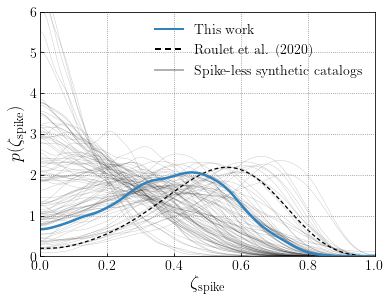

In [17]:
fig,ax = plt.subplots(figsize=(6,4.5))
grid = np.linspace(0,1,100)

# Plot results from this work and Roulet+
# Note that we are implicitly implementing symmetric boundary conditions in our KDE, ensuring normalization
ax.plot(grid,kde(grid) + kde(2.-grid) + kde(-grid),lw=2.5,color='#3182bd',zorder=2,label='This work')
ax.plot(grid,roulet_kde(grid) + roulet_kde(2.-grid) + roulet_kde(-grid),color='black',lw=1.3,dashes=(3,2),zorder=1)

# Loop across mock catalogs from null test
for catalog,result in nullData.items():
    
    # From each catalog, extract spike samples, KDE, and plot
    zeta_null_samples = result['posteriors']['zeta_spike']
    null_kde = gaussian_kde(zeta_null_samples,bw_method='scott')
    ax.plot(grid,null_kde(grid) + null_kde(2.-grid) + null_kde(-grid),color='black',alpha=0.2,lw=0.5,zorder=0)

# Manual legend
legend_lines = [Line2D([0], [0], color='#3182bd', lw=2),
                Line2D([0], [0], color='black', lw=2,dashes=(3,2)),
                Line2D([0], [0], color='black', lw=2,alpha=0.3)]
ax.legend(legend_lines, ['This work', 'Roulet et al. (2020)','Spike-less synthetic catalogs'],
          frameon=False,fontsize=14)
        
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel(r'$\zeta_\mathrm{spike}$',fontsize=18)
ax.set_ylabel(r'$p(\zeta_\mathrm{spike})$',fontsize=18)
ax.axes.grid(True,which='major',ls=':',color='grey')

ax.set_rasterization_zorder(1)
plt.savefig('figure_3.pdf',bbox_inches='tight',dpi=200)
plt.show()